**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Proyecto:**

**Datos de la entrega:** Jueves 21 de noviembre 2024

---

**Estudiantes:**
- Andrey Arguedas Espinoza

## • Prerequisites

### - This version is implemented in Anaconda Navigator, if you want to to run it on Google Colab make sure to have the Pro version and mount the instance
### - You need at leat 25GB RAM to run this project
### - Add the dataset to the same path you have the notebook so it loads inmediately

## • Import required libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Super important for these type of projects where plotting consumes a lot of resources
import random
import math
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, LSTM, TimeDistributed, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.editor import concatenate_videoclips

### • Define global variables for the project

In [2]:
# Path to UCF-101 dataset (replace with your path)
dataset_path = './UCF101/UCF-101/'

#Path of long untrimmed videos
long_videos_path = './longVideos/'


checkpoints_classification = 'checkpoints_classification'

#checkpoint filename to save
checkpoint_filename = 'detection_model{epoch:02d}.h5'
#checkpoint filename to load
checkpoint_filename_load = 'detection_model50.h5'

# Specify frame size (width, height) for resizing
frame_size = (50, 50)
frames_per_video = 90
batch_size = 128
epochs = 50

### • Functions to show video frames

In [3]:
# Function to read video frames
def read_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(frame)
    cap.release()
    return frames

# Function to visualize video frames in a multi-row grid
def visualize_video(frames, num_frames=16, num_rows=2):
    num_cols = num_frames // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    
    for i in range(num_frames):
        row = i // num_cols
        col = i % num_cols
        if i < len(frames):
            axes[row, col].imshow(frames[i])
        axes[row, col].axis('off')
        
    plt.tight_layout()
    plt.show()

### • Load the UFC-101

In [33]:
# Function to read video and resize frames
def load_video(video_path, frame_size=frame_size, num_frames=frames_per_video):
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        while len(frames) < num_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    finally:
        cap.release()

    # If video is shorter than num_frames, repeat last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames, dtype=np.uint8)


# Function to create dataset in NumPy array format
def create_ucf101_dataset(dataset_path, frame_size=frame_size, num_frames=0, load_until=6000):
    video_data = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        for video_file in os.listdir(class_dir):
            if  len(video_data) < load_until:
                video_path = os.path.join(class_dir, video_file)
                if num_frames == 0:
                    video_frames = load_complete_video(video_path, frame_size)
                else:
                    video_frames = load_video(video_path, frame_size, frames_per_video)
                video_data.append(video_frames)
                labels.append(label)
                if len(video_data) % 1000 == 0:
                    print("Amount of loaded videos", len(video_data))

    # Convert lists to NumPy arrays
    video_data = np.array(video_data, dtype=np.uint8)
    labels = np.array(labels, dtype=np.int32)

    return video_data, labels, len(video_data), class_names

In [34]:
# Create the dataset
dataset, labels, amount_of_videos, class_names = create_ucf101_dataset(dataset_path, frame_size=frame_size, num_frames=frames_per_video, load_until = 6000)

Amount of loaded videos 1000
Amount of loaded videos 2000
Amount of loaded videos 3000
Amount of loaded videos 4000
Amount of loaded videos 5000
Amount of loaded videos 6000


### • Choose a random video from the dataset and plot it

This video belongs to the class:  HandstandWalking


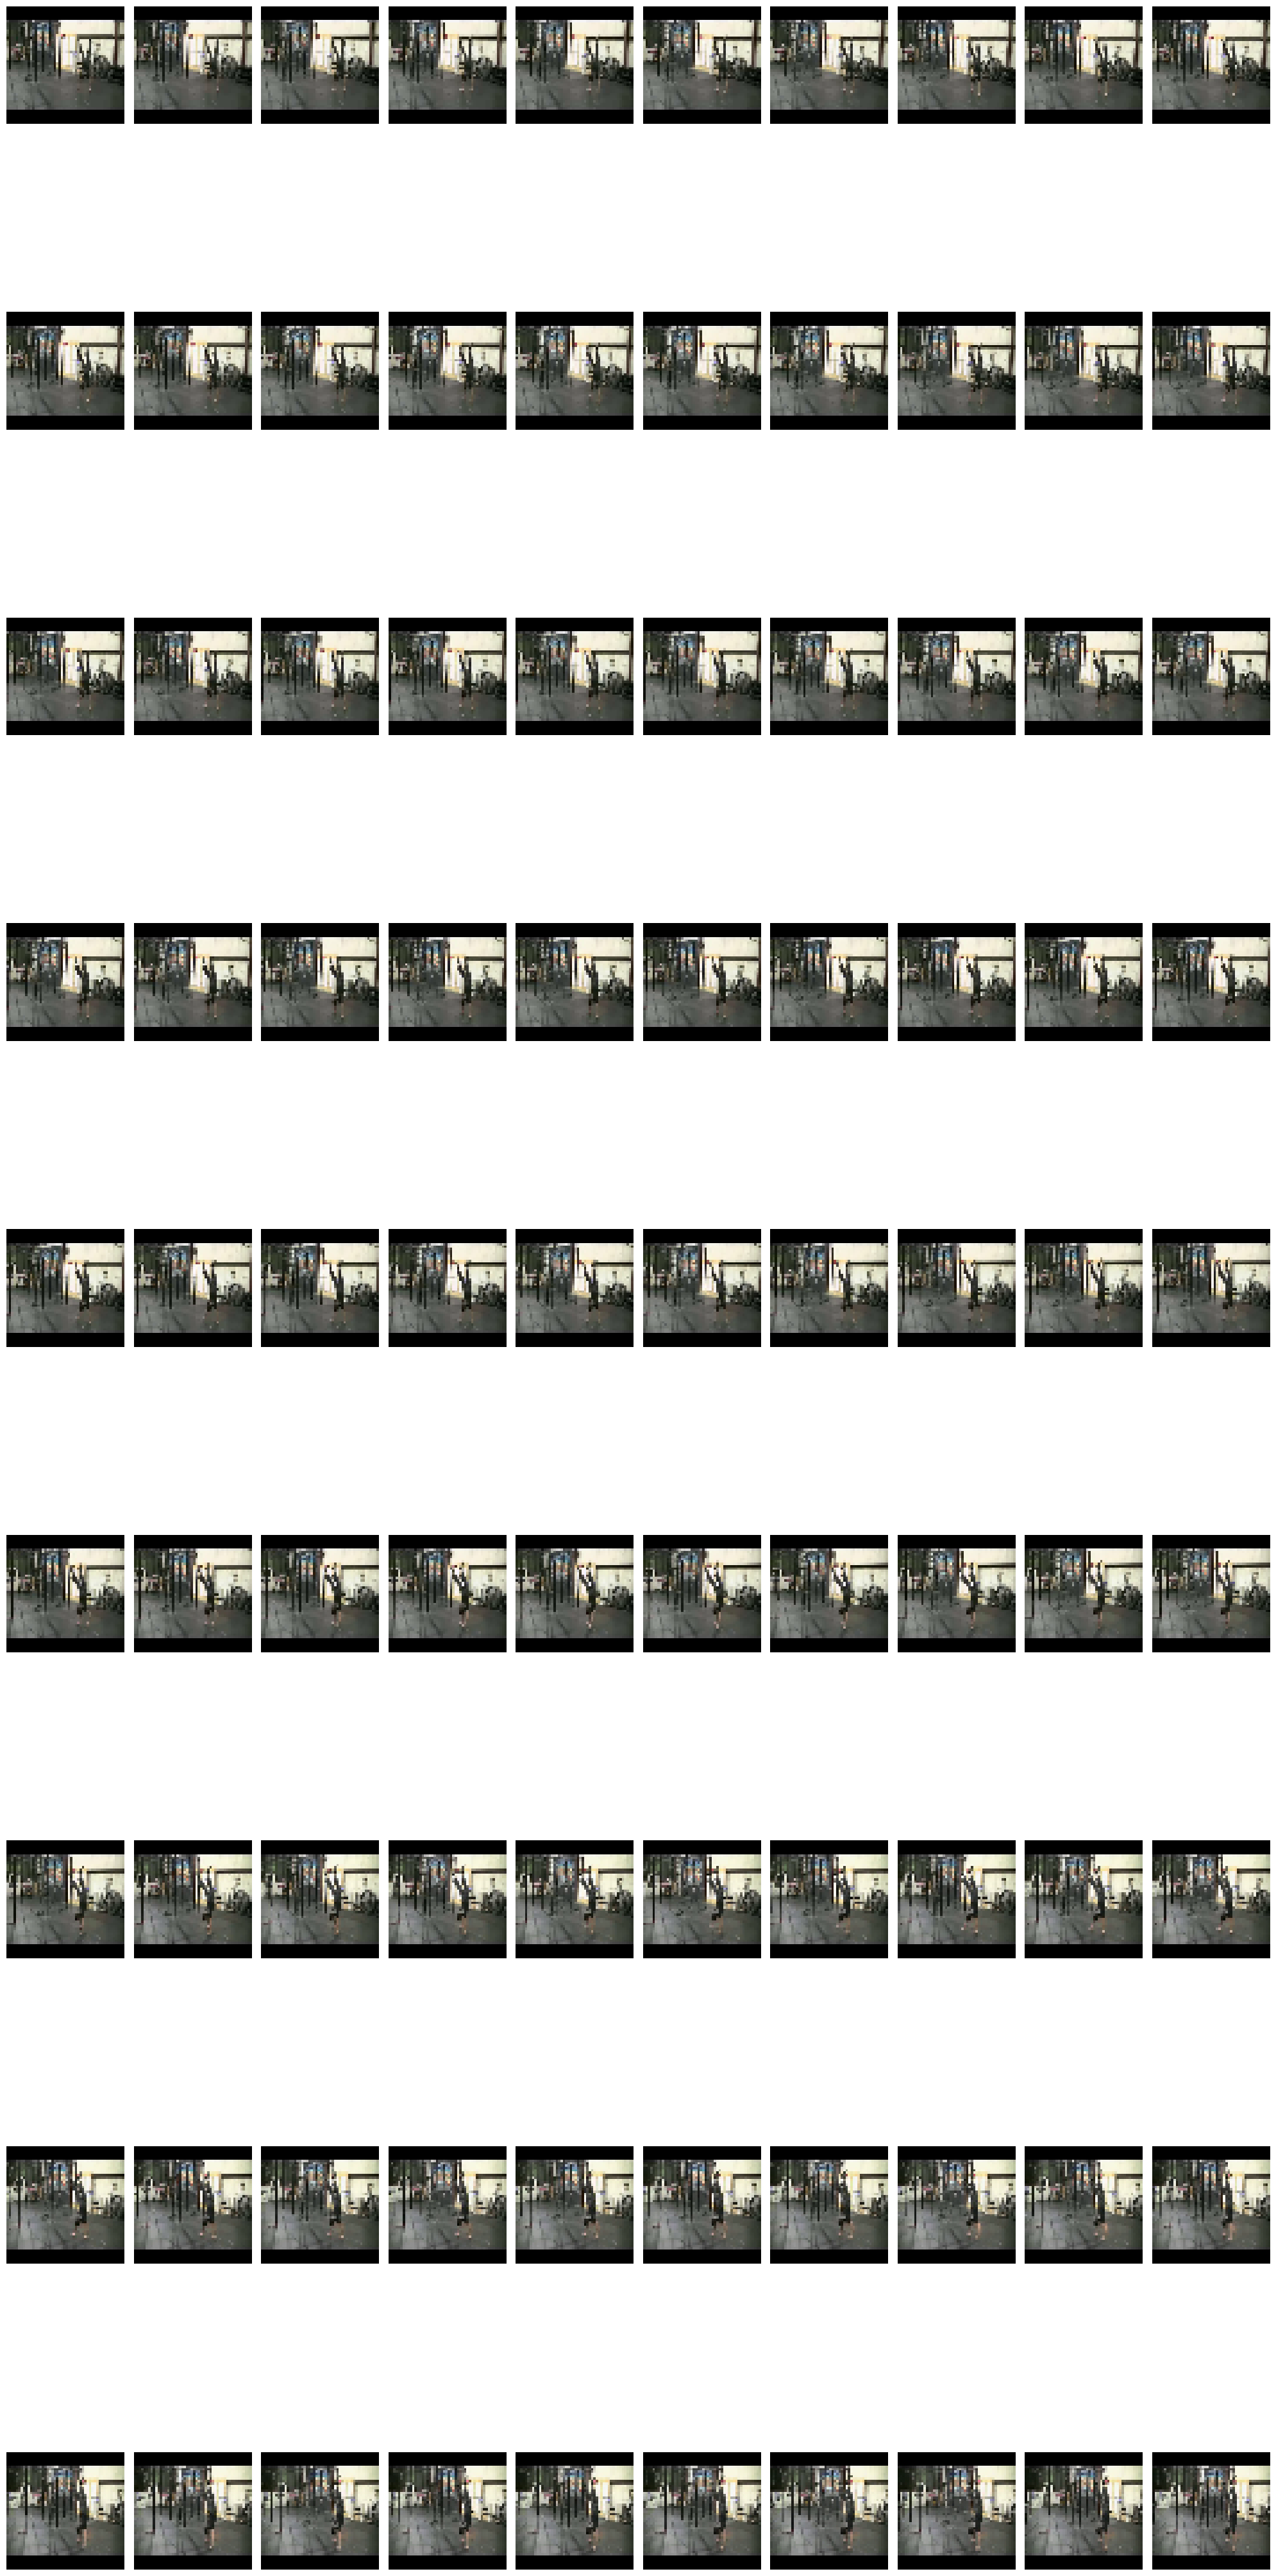

In [6]:
randomIndex = random.randint(0, dataset.shape[0])
print("This video belongs to the class: ", class_names[labels[randomIndex]])
visualize_video(dataset[randomIndex], num_frames=frames_per_video, num_rows=9)

### • Dataset split

### Important: We give a little more size to the validation partition this helped us reduced the overfitting we were having at the beggining

In [7]:
# Step 1: Split into train (70%) and remaining (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(dataset, labels, train_size=0.7)


# Step 2: Split remaining data into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.4)

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data: ", y_test.shape)


Dimensions of training data:  (4200, 90, 50, 50, 3)
Dimensions of training labels:  (4200,)
Dimensions of validation data:  (1080, 90, 50, 50, 3)
Dimensions of validation labels:  (1080,)
Dimensions of test data:  (720, 90, 50, 50, 3)
Dimensions of test data:  (720,)


### • Data normalization

In [8]:
X_train_normalized = X_train.astype('float32') / 255

X_val_normalized = X_val.astype('float32') / 255

X_test_normalized = X_test.astype('float32') / 255

#print("Example of frames transformation ", X_train_normalized[0])

#One Hot Encoding
y_train = to_categorical(y_train, num_classes=101)

y_val = to_categorical(y_val, num_classes=101)

y_test = to_categorical(y_test, num_classes=101)


### Architecture model

### We create an Action-Detection classification model with the help of 3D Convolusional Networks for the processing of the frames, and the LSTM to respect time dependencies

In [9]:
def build_action_detection_model(input_shape=(90, 60, 60, 3), num_classes=101):
    model = Sequential()

    # Reduced 3D CNN for spatio-temporal feature extraction
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten output and pass through LSTM
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256, return_sequences=False))

    # Fully connected layers with fewer units
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [24]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_action_detection_classification_model_loaded_from_disk = False

if os.path.isfile(checkpoints_classification + '/'  + checkpoint_filename_load):
    print("Loading saved classification model!!!")
    action_detection_model = tf.keras.models.load_model(checkpoints_classification + '/'  + checkpoint_filename_load)
    was_action_detection_classification_model_loaded_from_disk = True
else:
    print("Creating classification model!!!")
    action_detection_model = build_action_detection_model(input_shape=(frames_per_video, frame_size[0], frame_size[1], 3))
    
action_detection_model.summary()

Loading saved classification model!!!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 88, 48, 48, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 88, 48, 48, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 88, 24, 24, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 86, 22, 22, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 86, 22, 22, 64)   256       
 hNormalization)                                                 
                  

# *********************** Training phase *************************

### We use this common function to train all the architectures of our project, it also creates the checkpoints that we will save for each architecture

In [11]:
# Training the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, initial_epoch = 0, epochs=5, checkpoint_dir=''):
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

    # Create checkpoints folder
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, checkpoint_filename),
        save_weights_only=False,  # Save the entire model, not just weights
        save_best_only=False,     # Save the model after every epoch, not just the best one
        monitor='loss',
        mode='min'
    )
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), initial_epoch=initial_epoch, callbacks=[checkpoint_cb])
    return history

In [12]:
def visualize_metrics(history, under_lim = -1, upper_lim = 5):
    pd.DataFrame(history.history).plot(figsize=(10, 7))
    plt.grid(True)
    plt.gca().set_ylim(under_lim, upper_lim)
    plt.xlabel("epochs")
    plt.show()

In [25]:
if was_action_detection_classification_model_loaded_from_disk is False:
    history = train_model(action_detection_model, X_train_normalized, y_train, X_val_normalized, y_val, batch_size=batch_size, epochs=epochs, checkpoint_dir=checkpoints_classification)
    visualize_metrics(history)
#else:
    #For now keep training until epoch 50
    #print("Continue with training")
    #history = train_model(action_detection_model, X_train_normalized, y_train, X_val_normalized, y_val, batch_size=batch_size, epochs=epochs, initial_epoch = 7, checkpoint_dir=checkpoints_classification)
    #visualize_metrics(history)

# *************************** Test phase ********************************

### • Here we will compare and test all the architectures

In [14]:
test_loss, test_acc, test_prec = action_detection_model.evaluate(X_test_normalized, y_test)
print('Test accuracy: ', test_acc)
print('Test Precision:', test_prec)
print('Test Loss:', test_loss)

23/23 [==============================] - 25s 1s/step - loss: 0.3350 - accuracy: 0.9278 - precision: 0.9379
Test accuracy:  0.9277777671813965
Test Precision: 0.937940776348114
Test Loss: 0.3350202441215515


In [15]:
# Evaluación del modelo
predicted = action_detection_model.predict(X_test_normalized)

23/23 [==============================] - 25s 1s/step


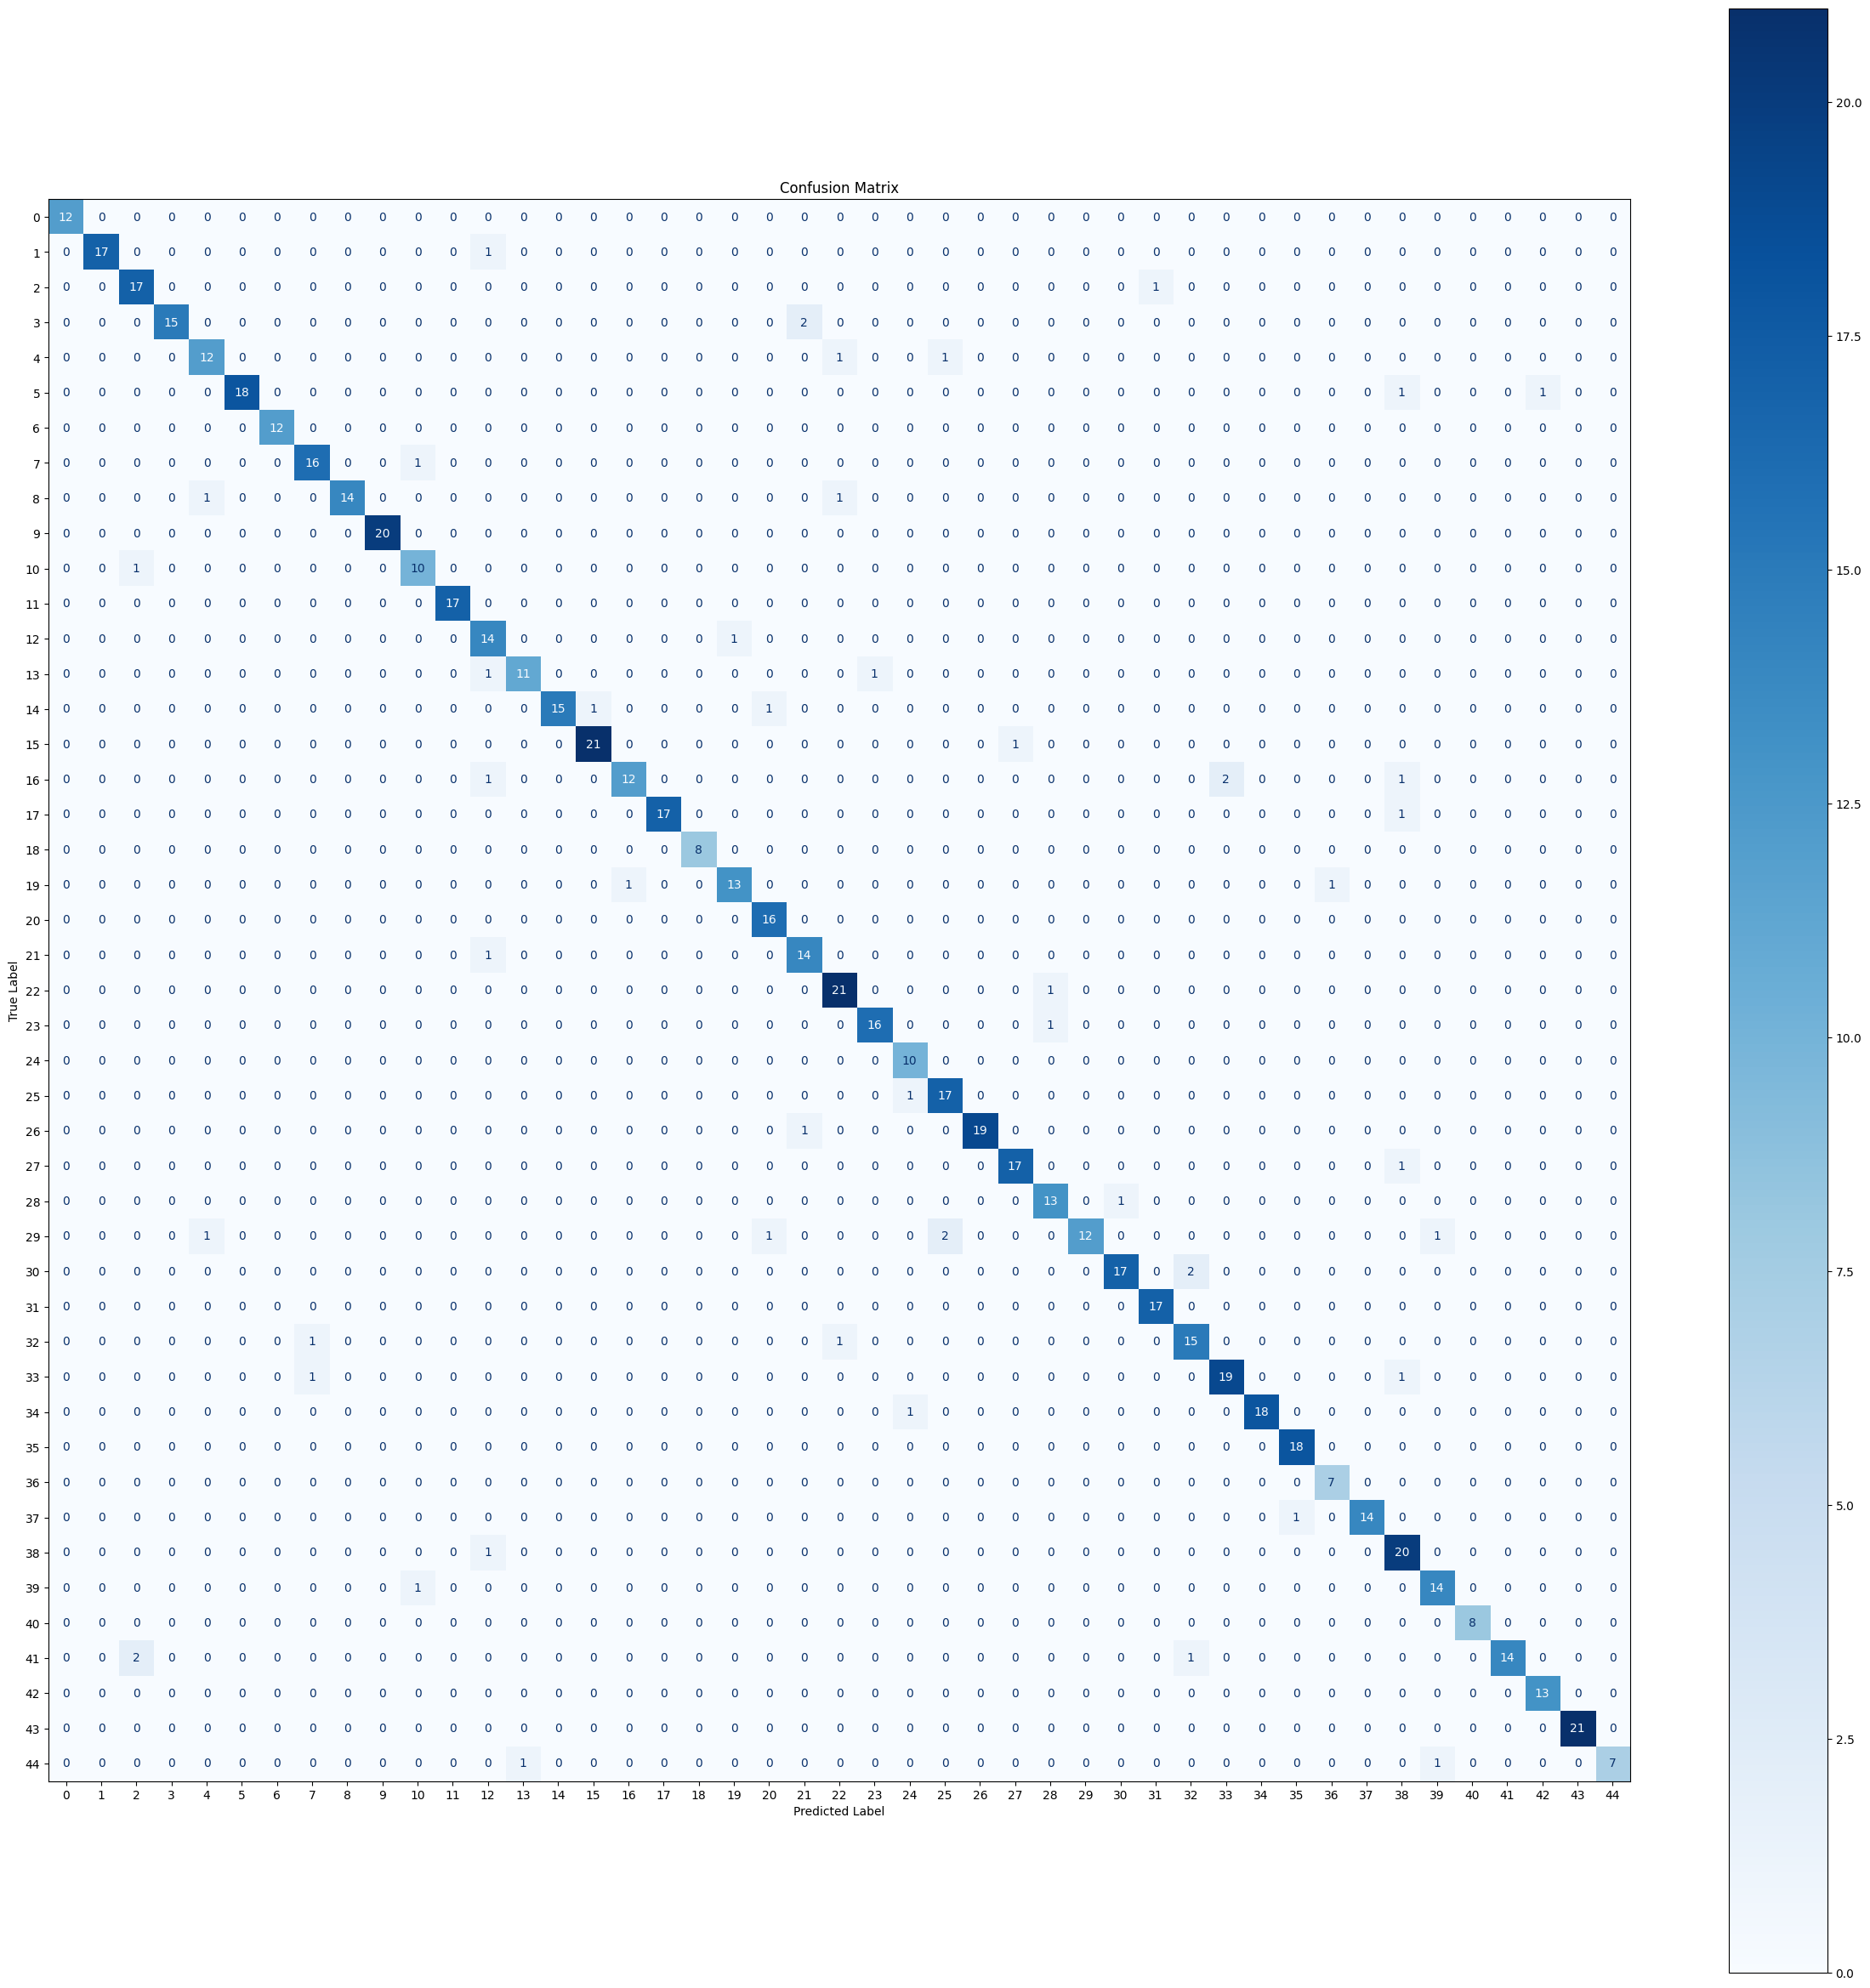

In [16]:
# Generate the confusion matrix
predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(30, 30))  # Set the figure size if needed
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### • Pick 5 random videos from test lets plot it and compare the predicted class vs the original

Predicted class:  ApplyLipstick
Original class:  ApplyLipstick


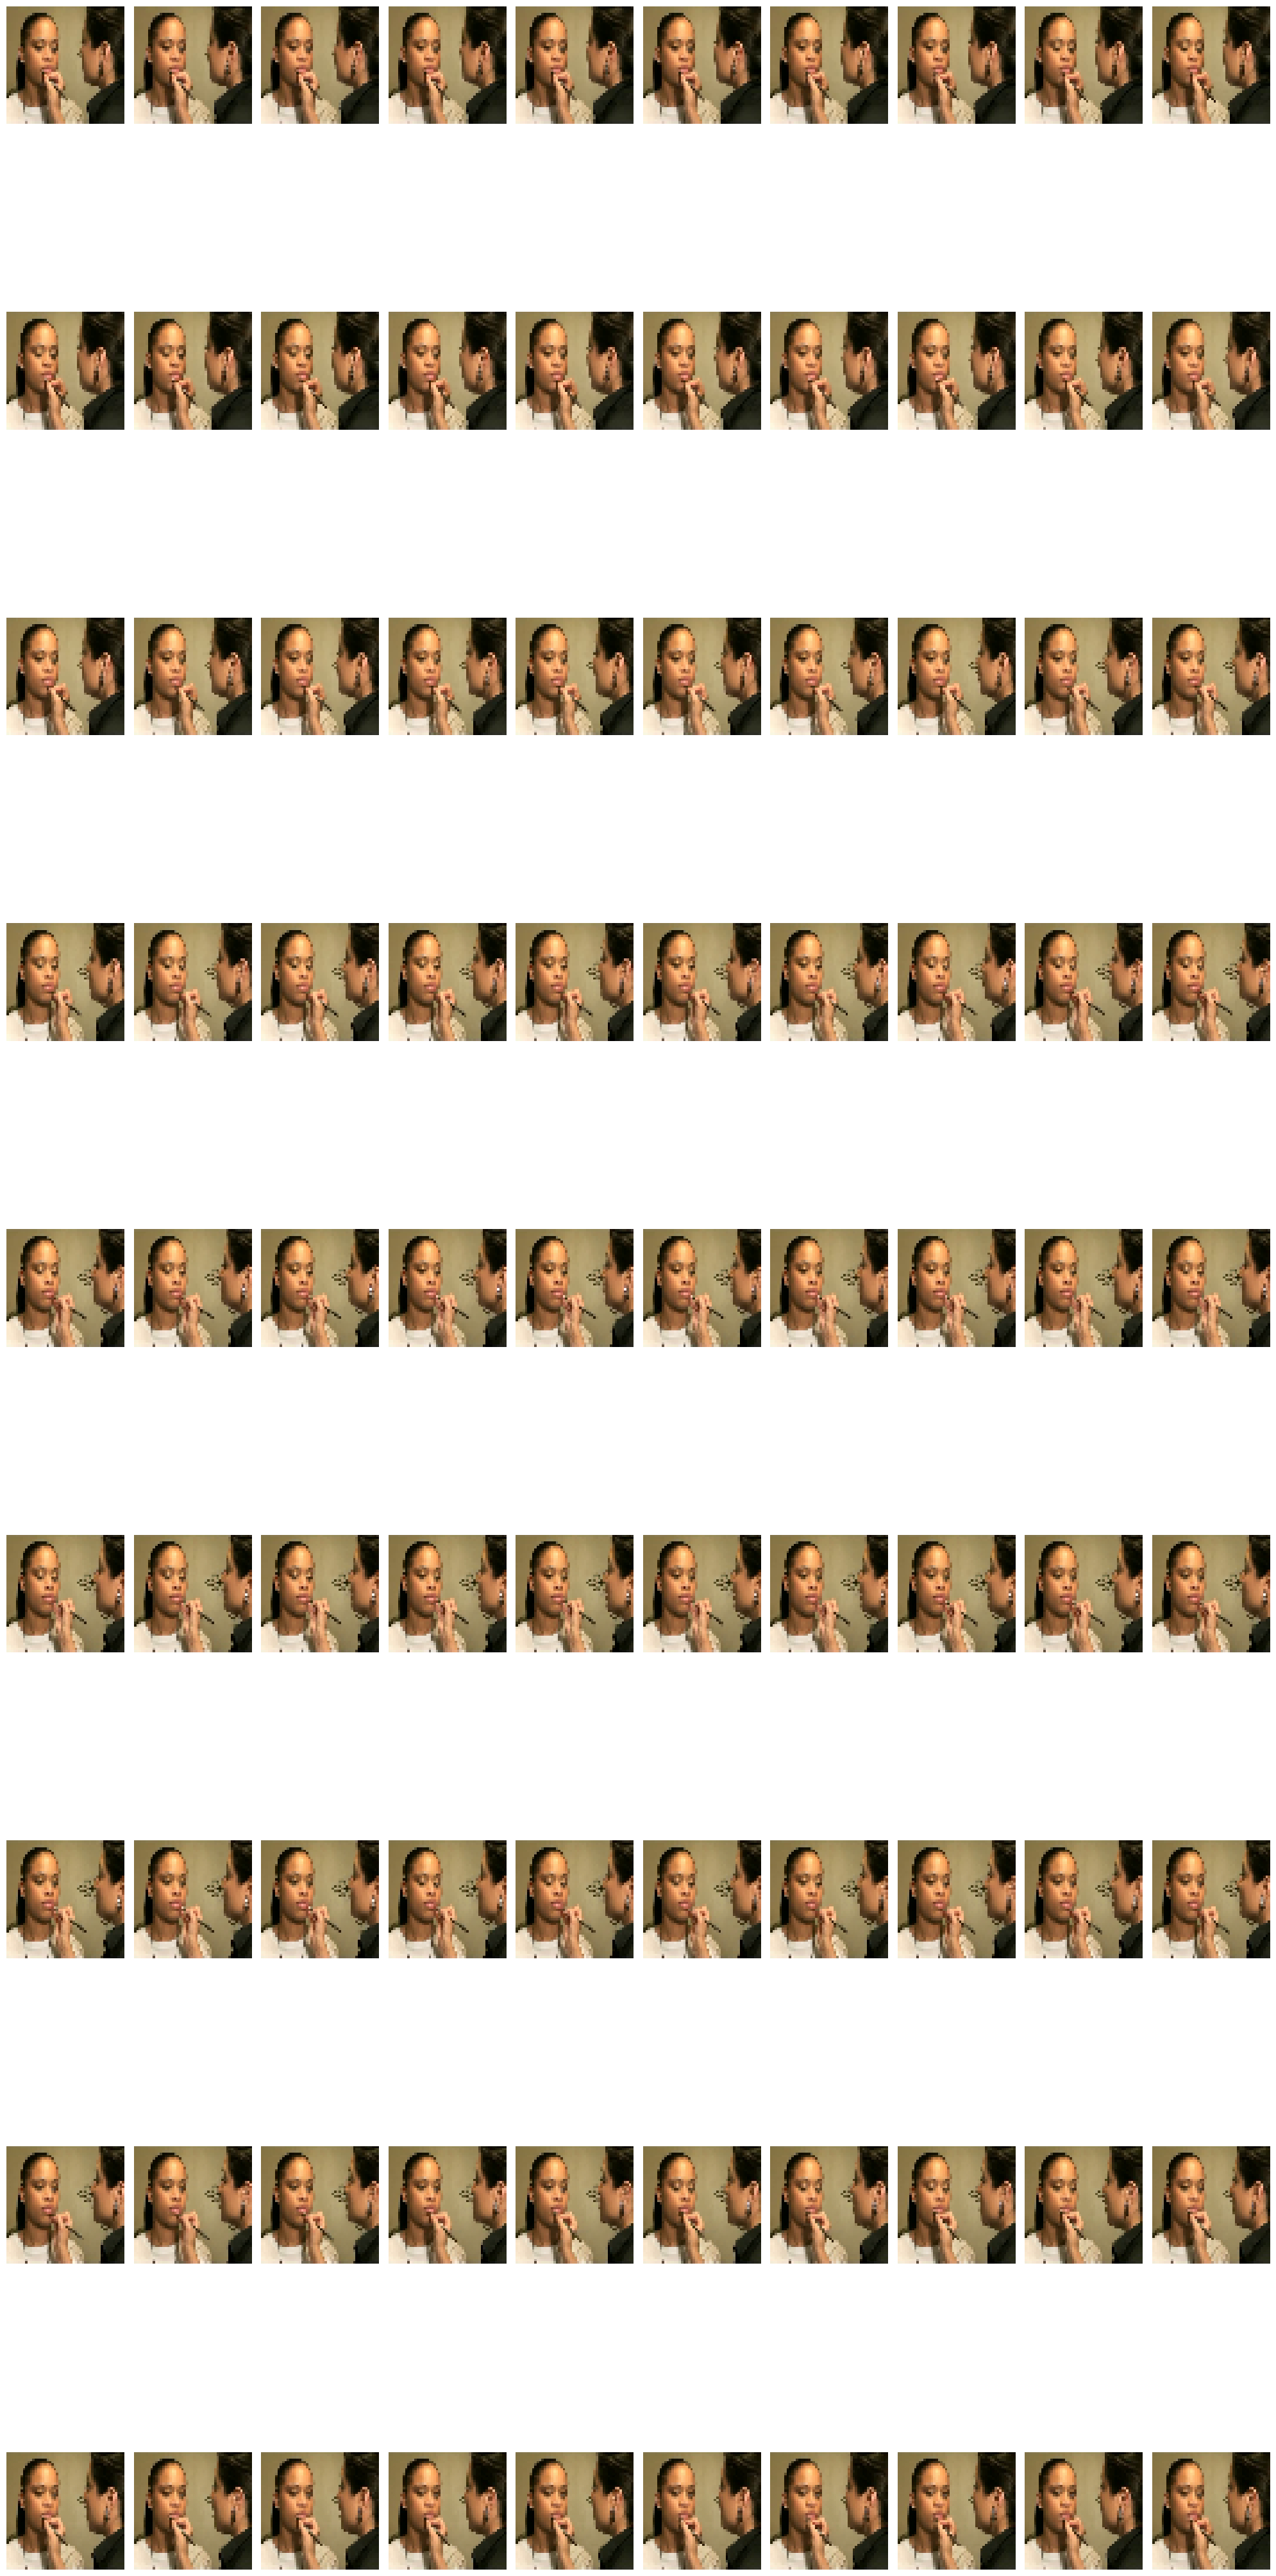

Predicted class:  FloorGymnastics
Original class:  FloorGymnastics


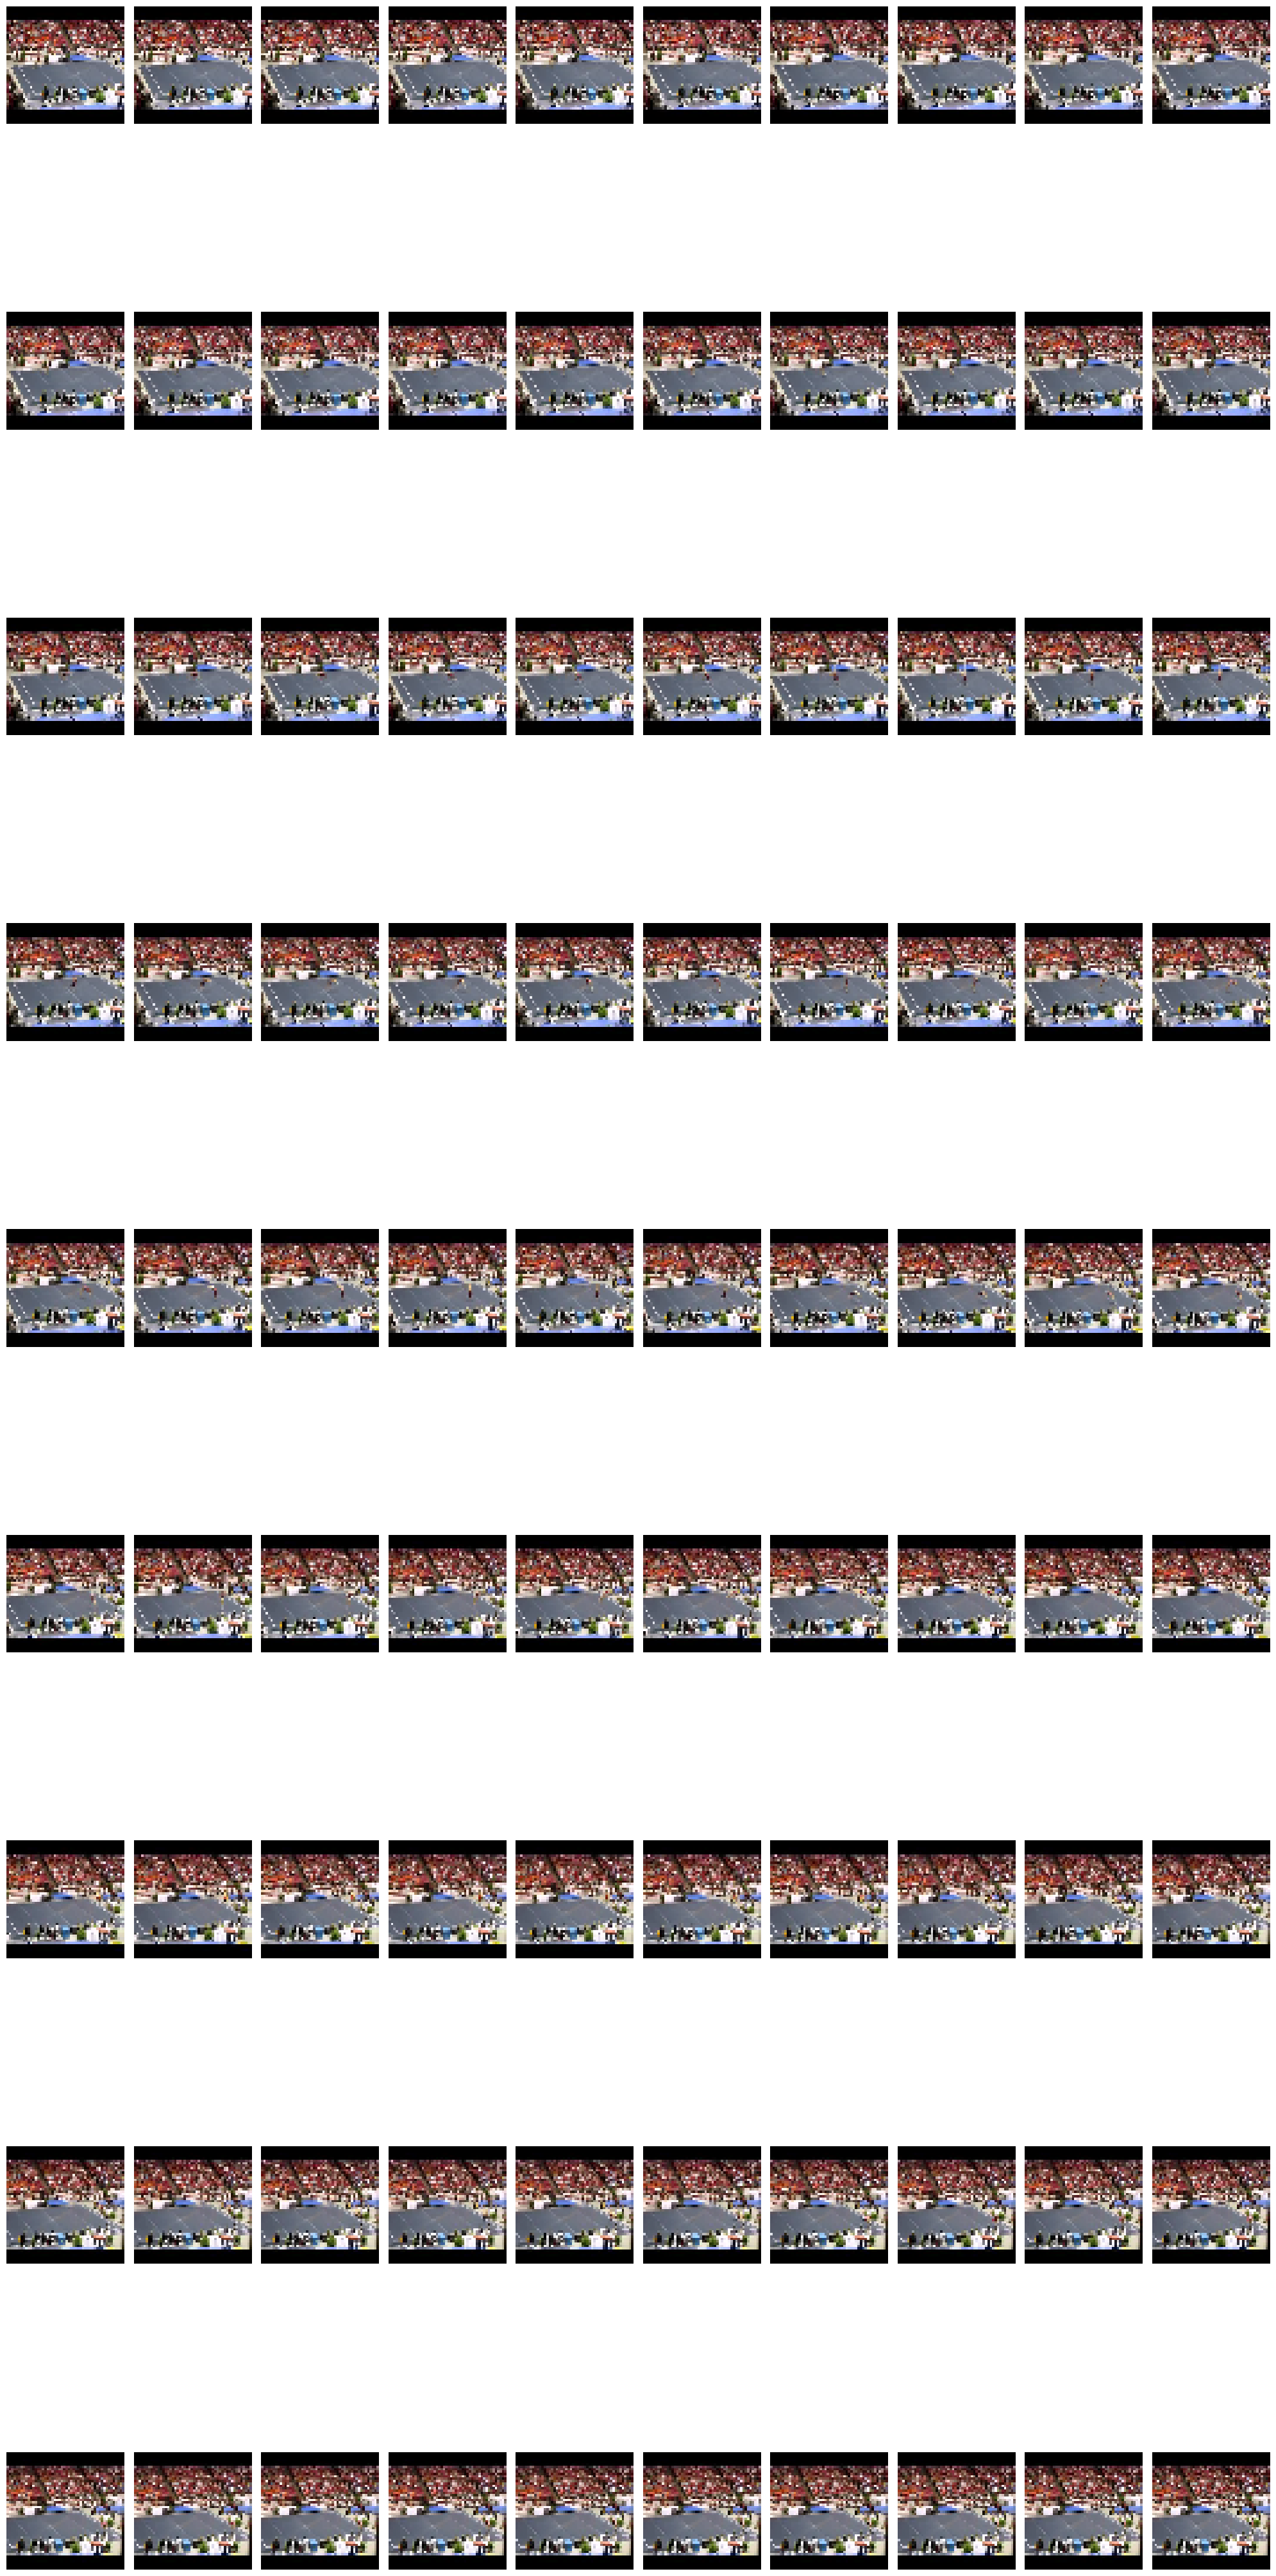

Predicted class:  Bowling
Original class:  Bowling


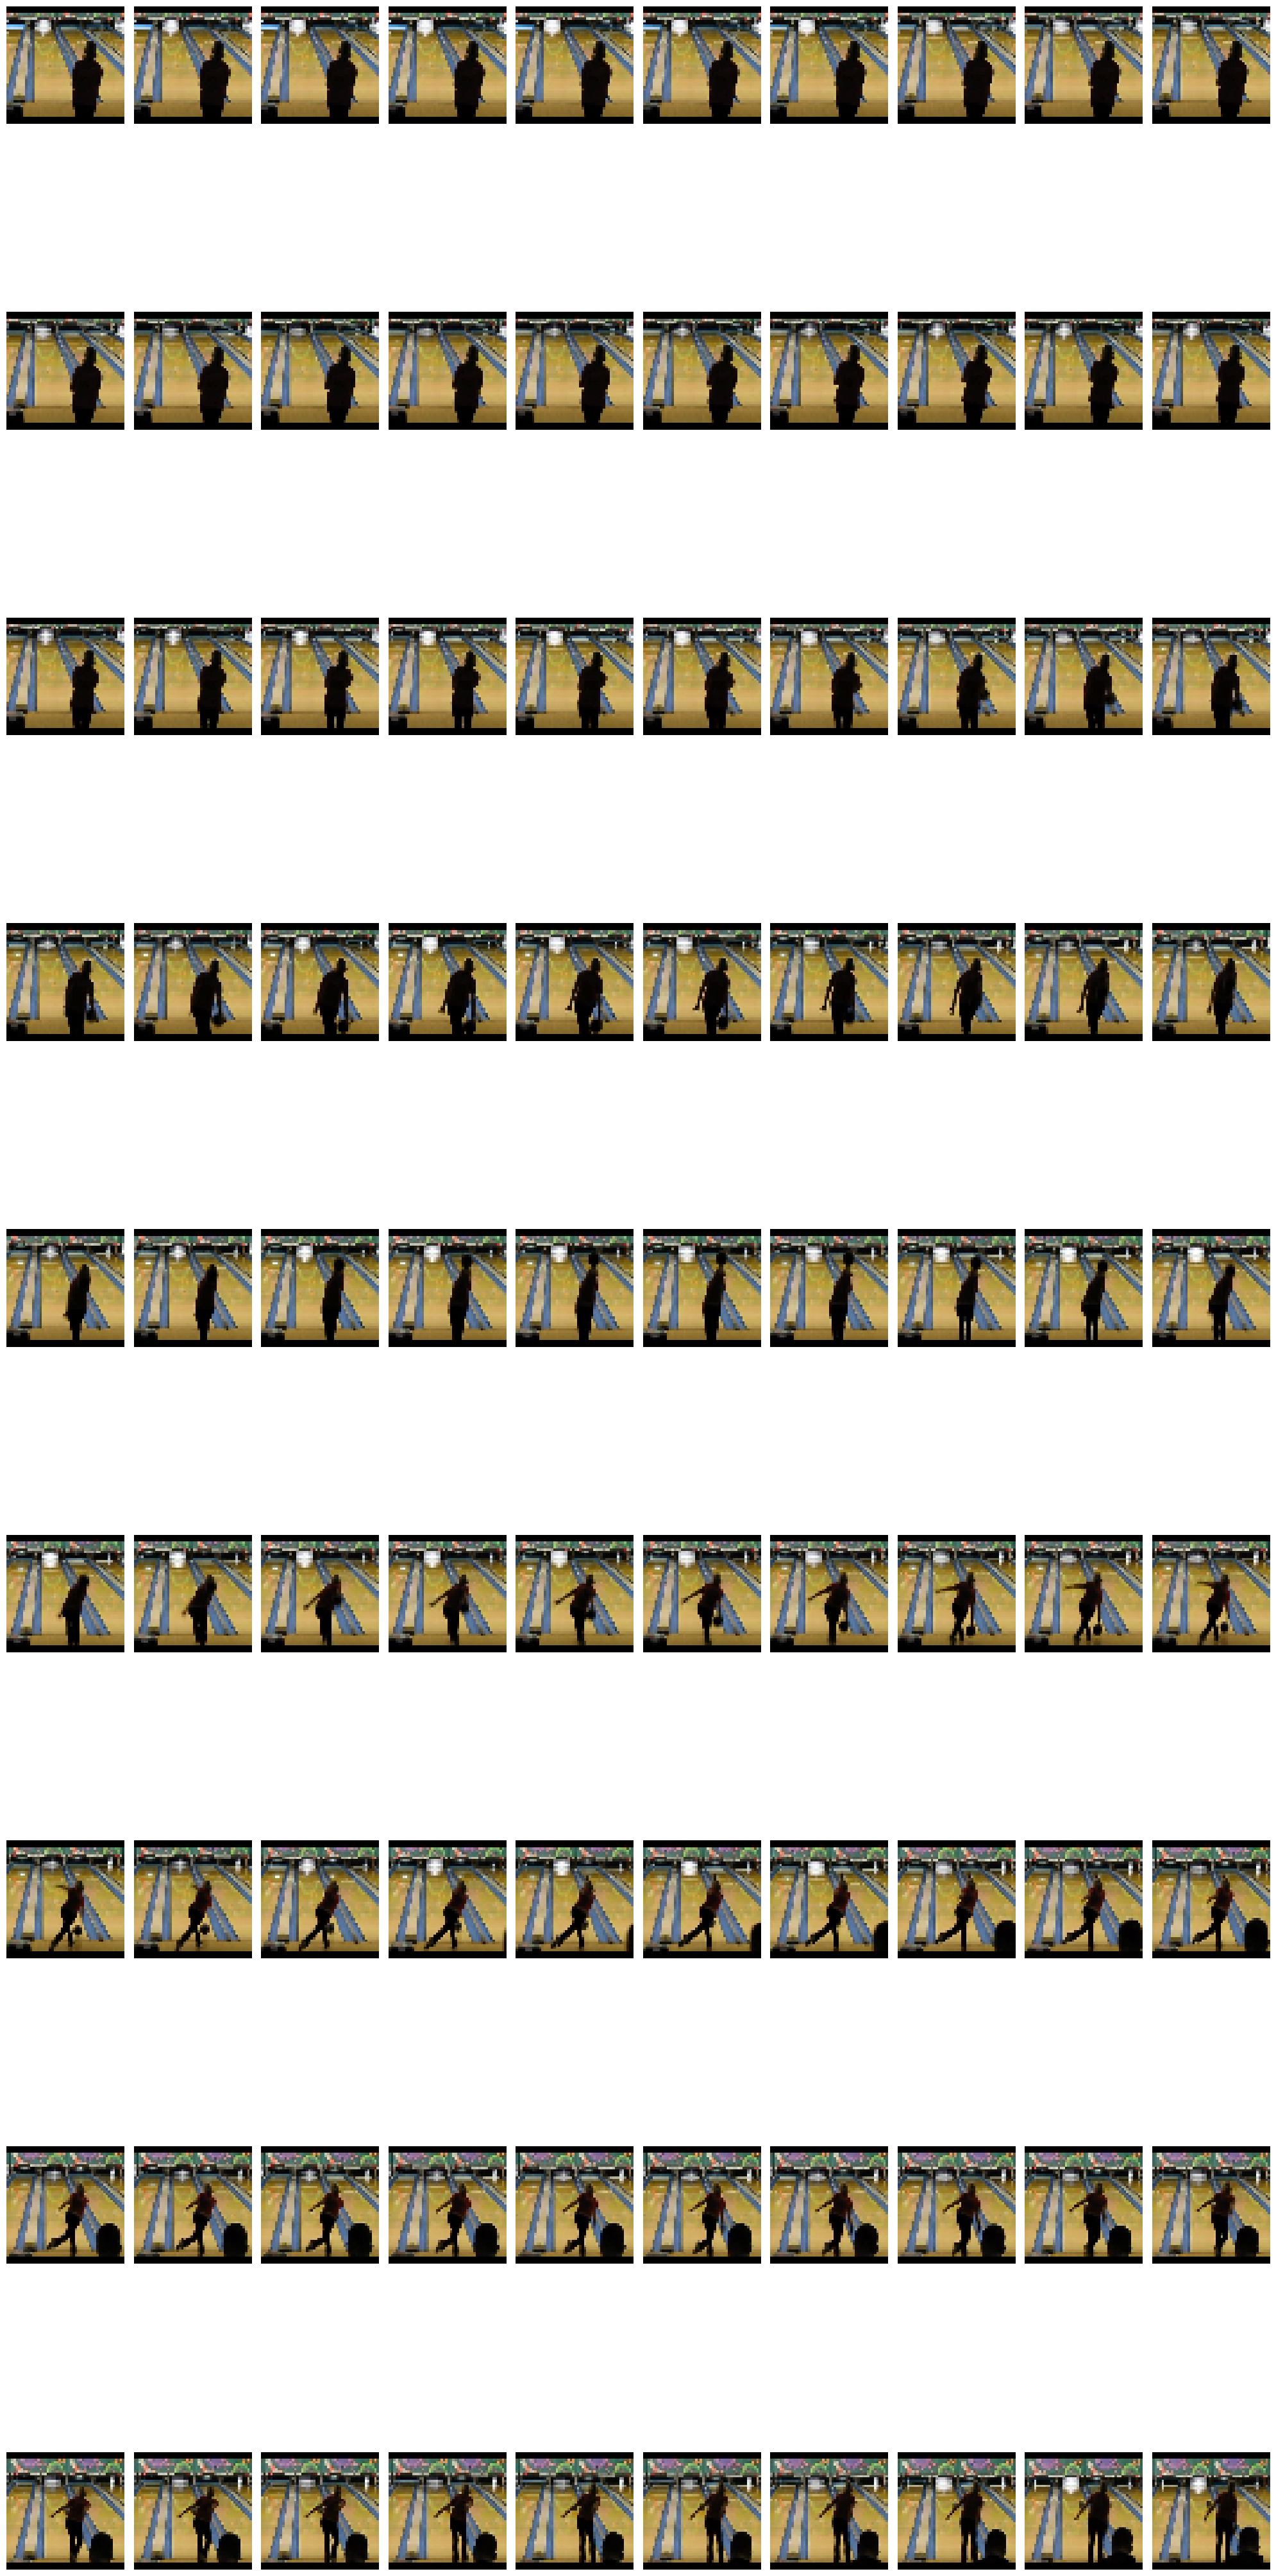

Predicted class:  BenchPress
Original class:  BenchPress


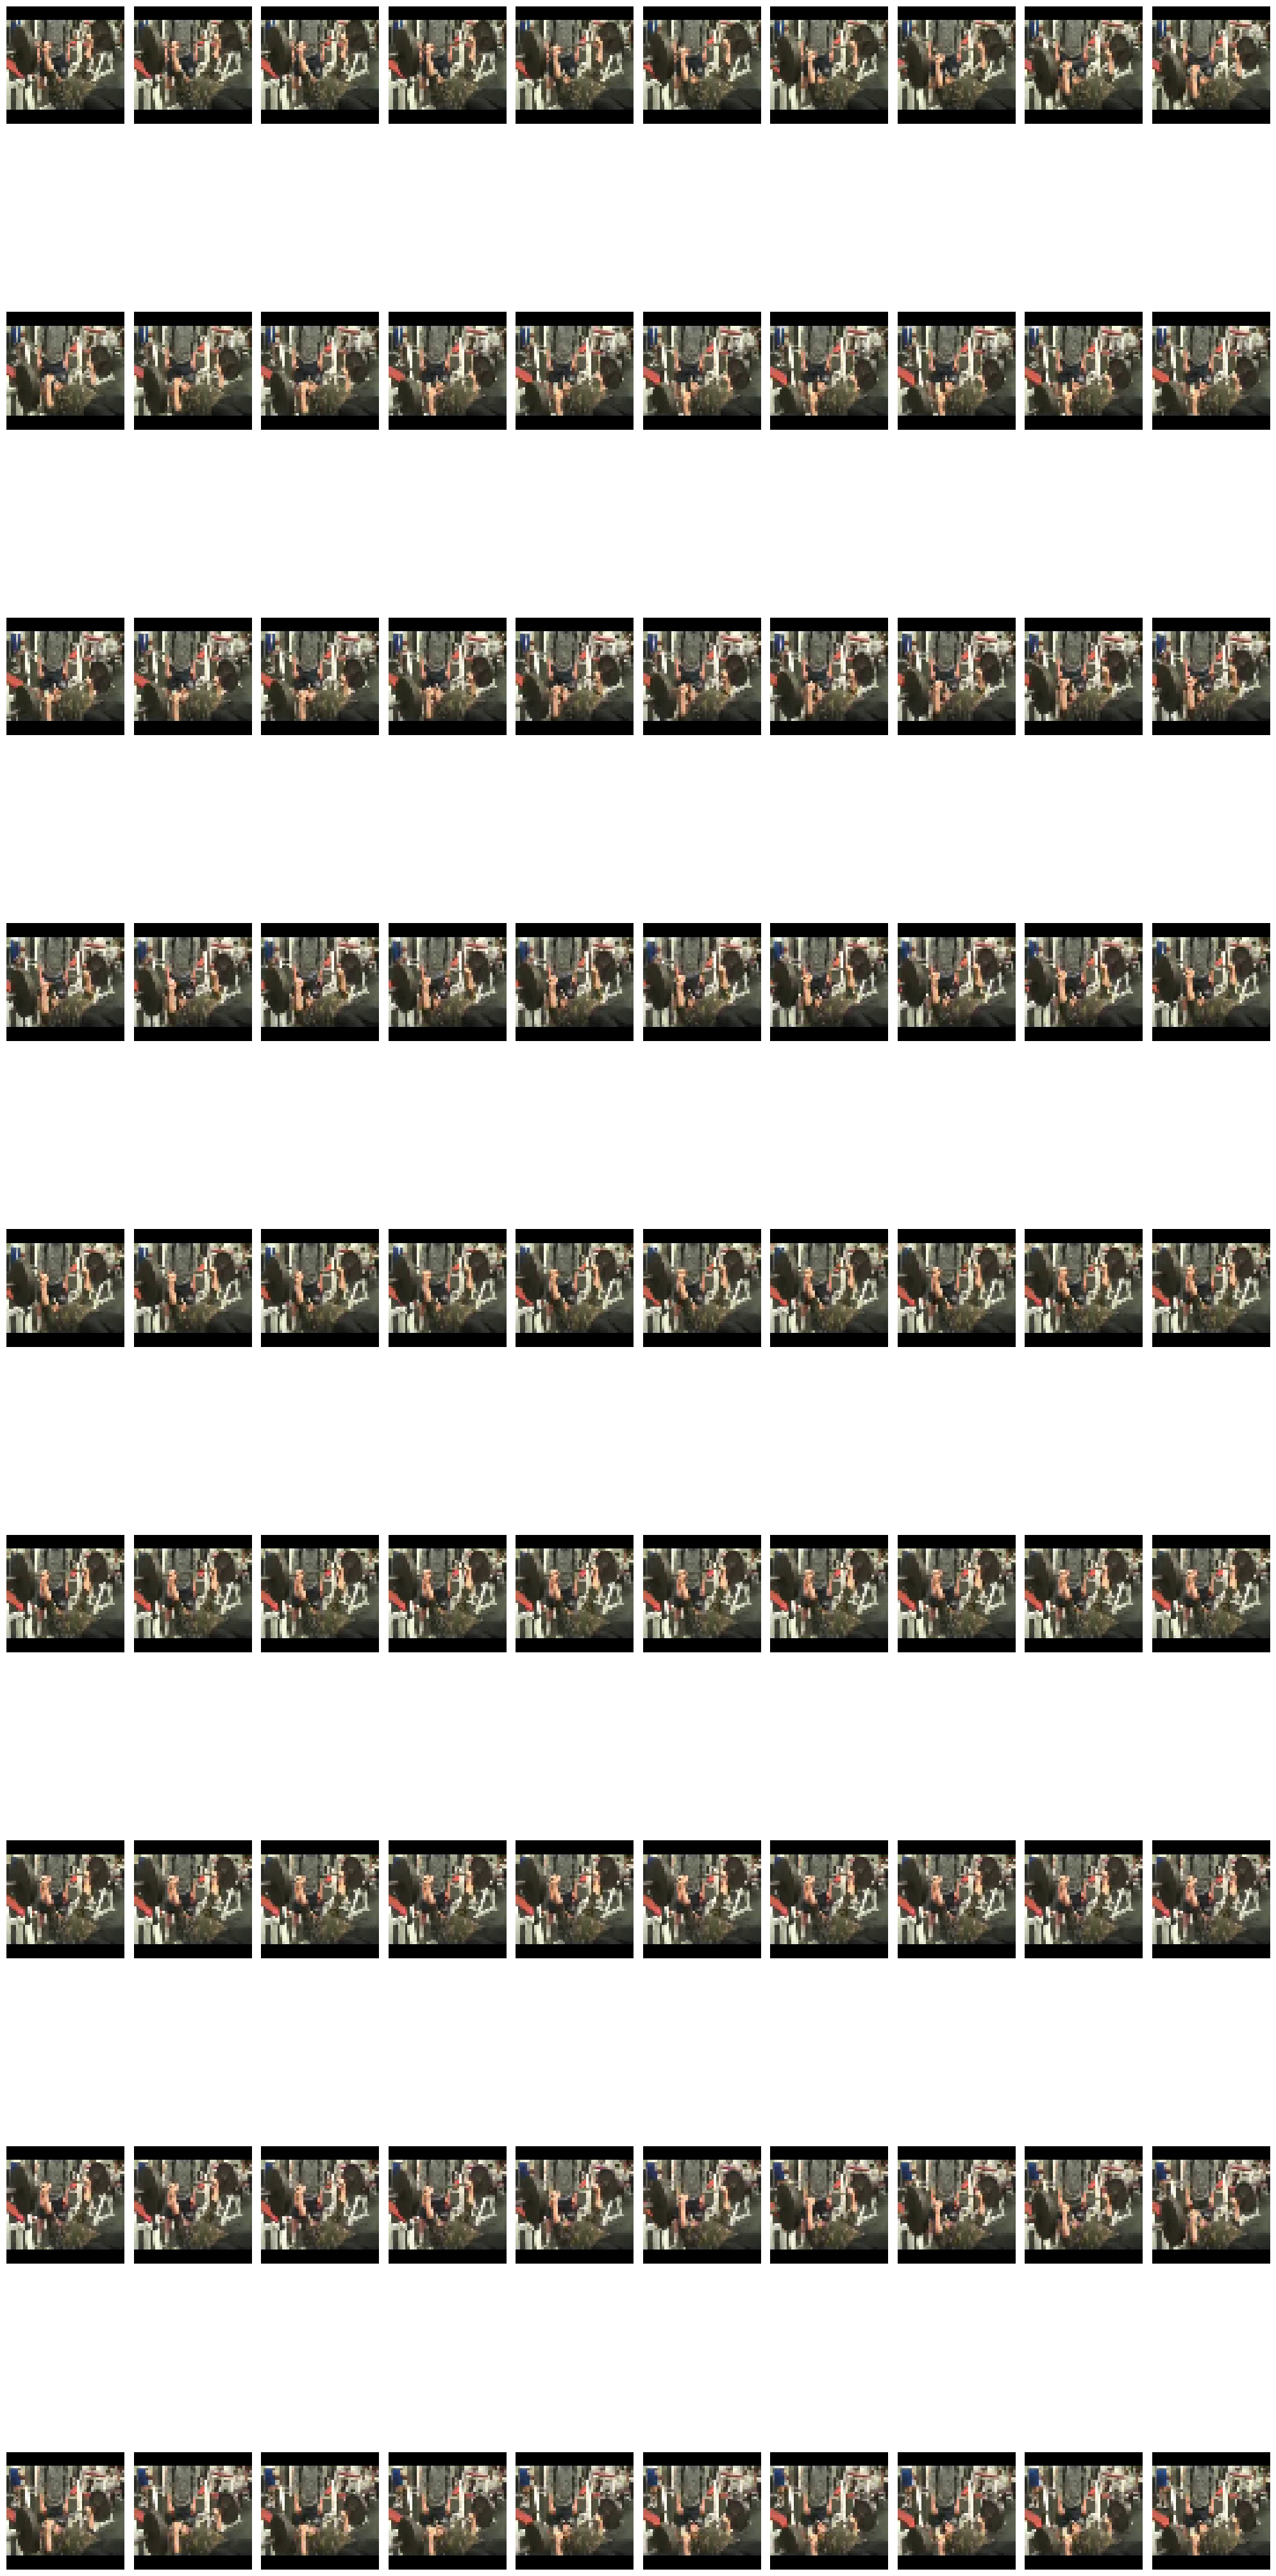

Predicted class:  Billiards
Original class:  Billiards


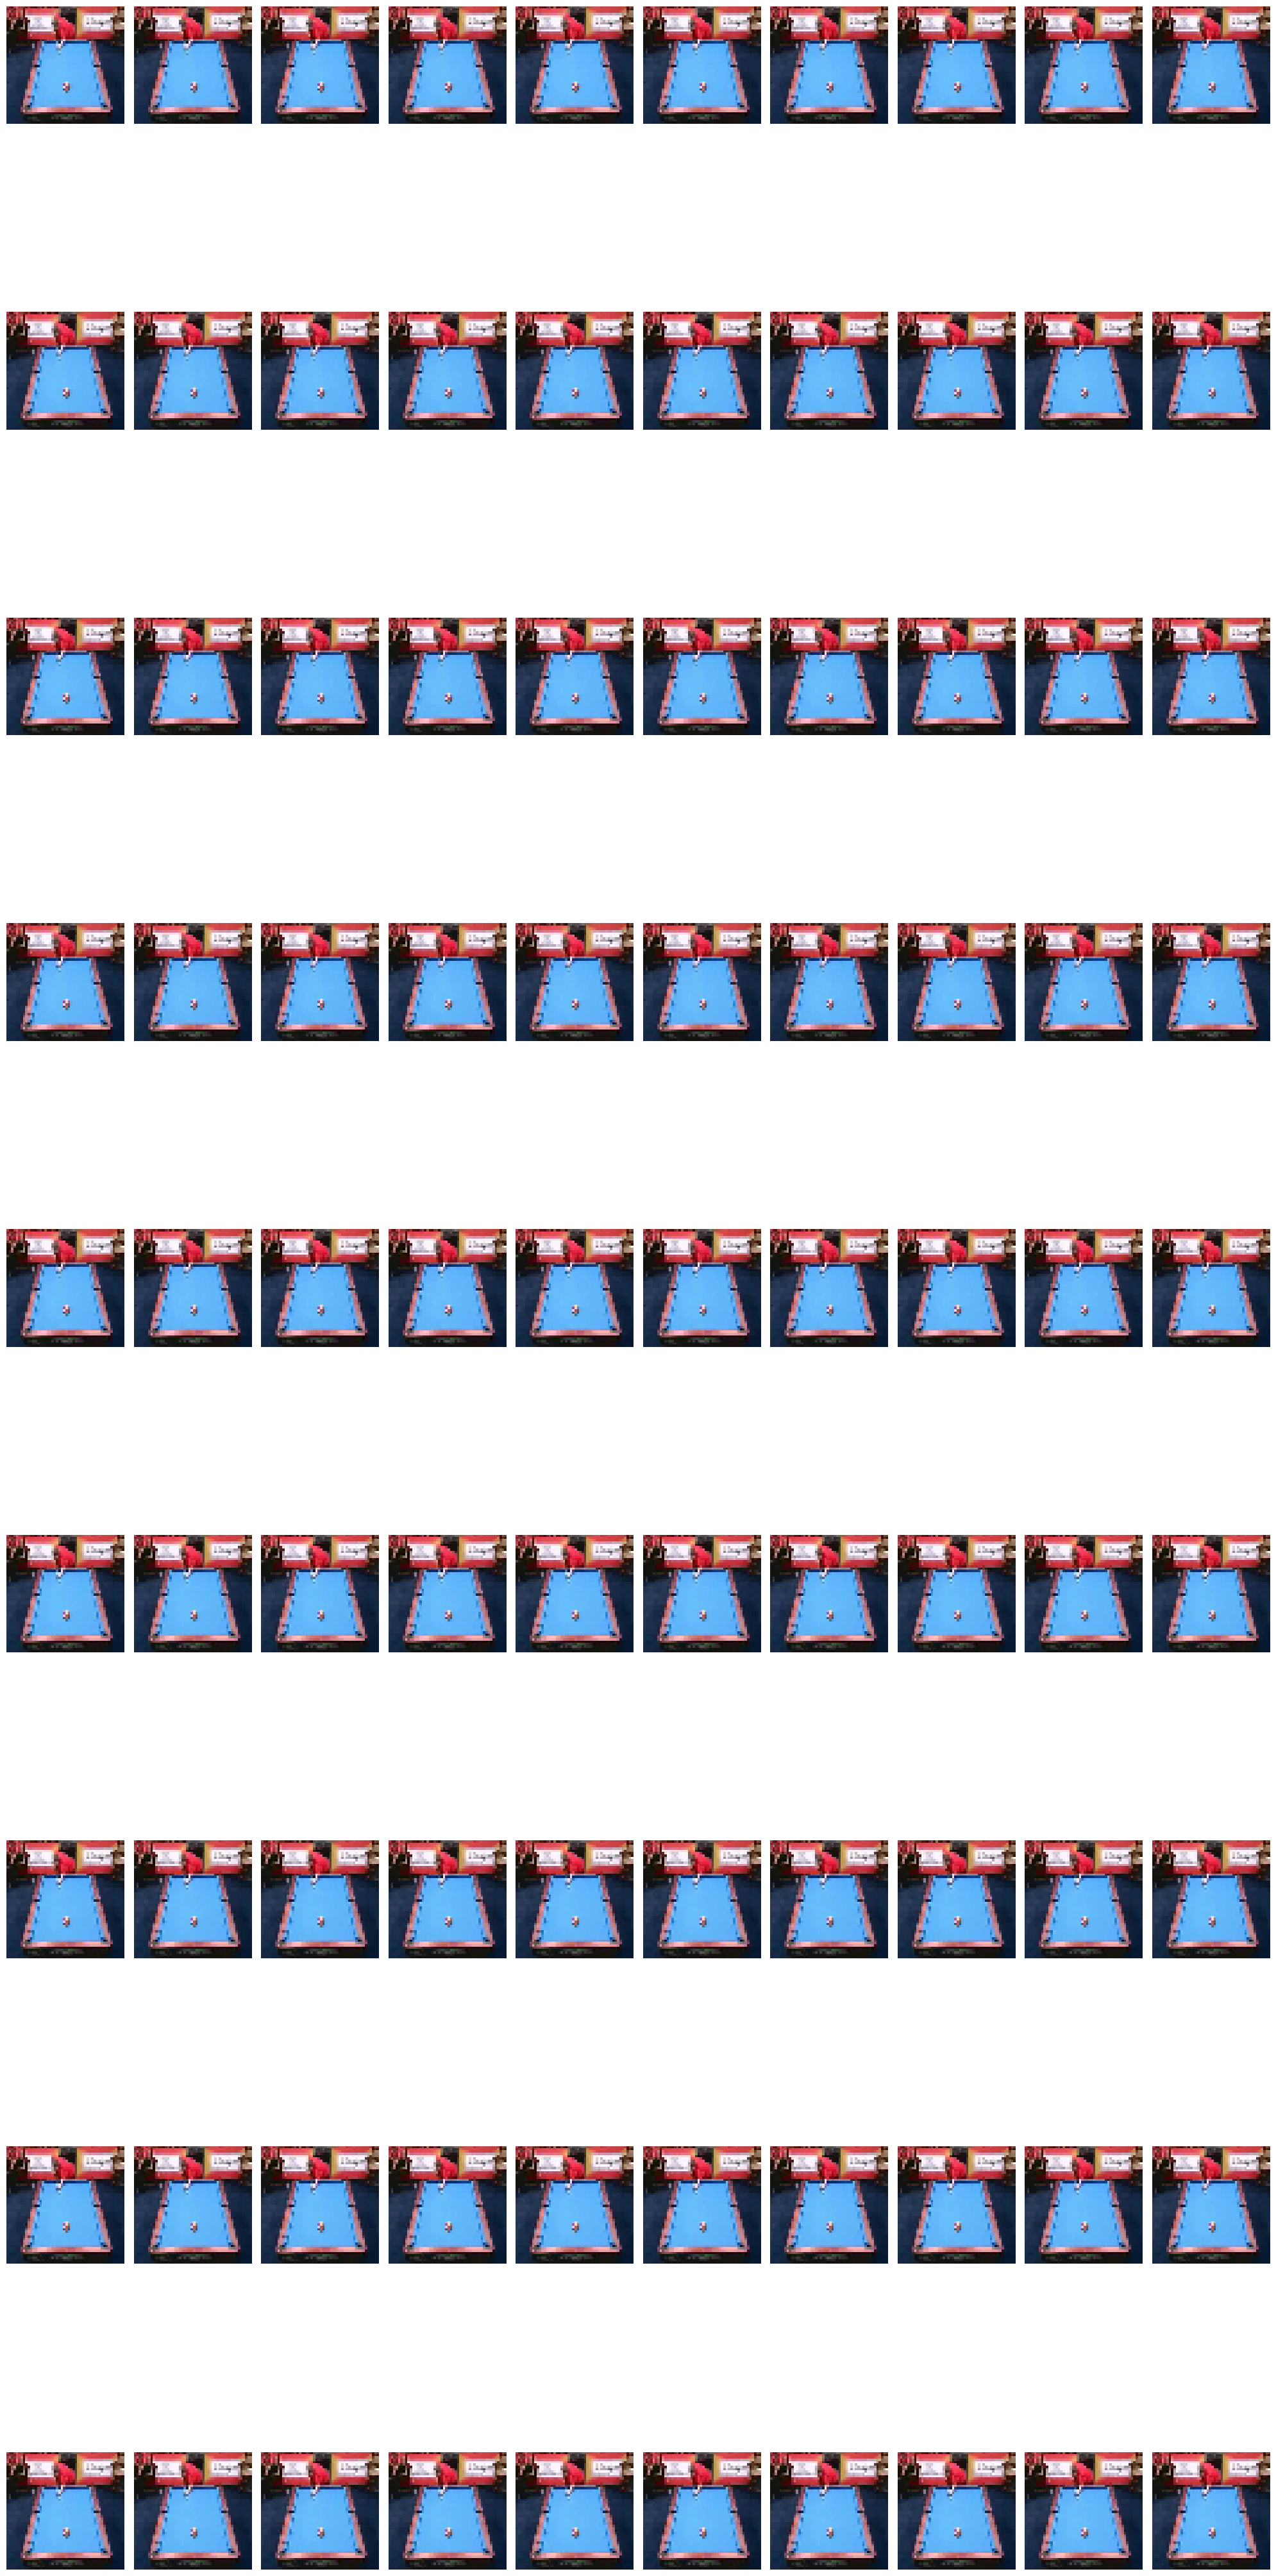

In [17]:
randomVideosIndex=[random.randint(0, len(X_test_normalized)) for x in range(5)]

for i in randomVideosIndex:
    originalVideo = X_test_normalized[i] 
    print("Predicted class: ", class_names[predicted[i]])
    print("Original class: ", class_names[y_test[i]])
    visualize_video(originalVideo, num_frames=frames_per_video, num_rows=9)

### • Create a window approach for trimming long videos

### • Load the long videos 

### This videos contain a lot of footage but we want to trim only the parts that we are interested based on the model predicted classification

In [75]:
def load_complete_video(video_path, frame_size=(60, 60)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    finally:
        cap.release()
    
    return np.array(frames, dtype=np.uint8)

### Function to load full videos
# Function to create dataset in NumPy array format
def load_full_videos(long_videos_path, frame_size=frame_size):
    video_data = []
    labels = []
    video_names = []
    class_names = sorted(os.listdir(long_videos_path))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(long_videos_path, class_name)
        for video_file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_file)
            video_frames = load_complete_video(video_path, frame_size)
            video_data.append(video_frames)
            labels.append(label)
            video_names.append(video_file)

    #video_data = np.array(video_data, dtype=np.uint8)
    labels = np.array(labels, dtype=np.int32)

    return video_data, labels, len(video_data), class_names, video_names


In [76]:
long_videos_dataset, long_videos_labels, long_videos_amount_of_videos, long_videos_class_names, long_video_names = load_full_videos(long_videos_path, frame_size=frame_size)

In [77]:
print(long_videos_labels, long_video_names)

[0 1 2] ['video_validation_0000574.mp4', 'video_validation_0000152.mp4', 'video_validation_0000673.mp4']


### • Now split the long video in windows of 3 seconds each (90 frames)

In [78]:
def splitten_videos_windows(long_videos_dataset, frames_per_video):
    sequence_of_small_videos = []
    for longVideo in long_videos_dataset:
        long_video_frames = longVideo.shape[0]
        # Determine the number of chunks and reshape accordingly
        chunk_size = frames_per_video
        num_chunks = math.floor(long_video_frames / frames_per_video)
        # Slice the first X elements and reshape into (90, 50, 50, 3)
        splittenVideo = longVideo[:num_chunks * chunk_size].reshape((num_chunks, chunk_size, frame_size[0], frame_size[1], 3))
        sequence_of_small_videos.append(splittenVideo)
    return sequence_of_small_videos


### • Relevant classes : In here we define a set of relevant classes, for example the video contains a band marching video, but this is really similar to a Military Parade and there is also Drumming parts that we would like to have in our final trimmed video so we are going to use all these for our final output

In [79]:
def generate_trim_clips_times(relevantClasses, windows_amount, class_names, predicted_small_video):
    trim_clips_video = []
    seconds_size = frames_per_video / 30
    for i in range(0, windows_amount):
        print("Predicted class: ", class_names[predicted_small_video[i]])
        if(predicted_small_video[i] in relevantClasses):
            trim_clips_video.append((seconds_size * i, seconds_size * i + seconds_size))
    return trim_clips_video

### • Common function to trim videos

In [80]:
def trim_video(input_path, output_path, trim_intervals):
    """
    Trims a video to the specified intervals and combines them into a single output.

    Parameters:
    - input_path (str): Path to the input video file.
    - output_path (str): Path to save the trimmed video file.
    - trim_intervals (list of tuples): List of (start_time, end_time) tuples in seconds.
    """
    # Load the video file
    with VideoFileClip(input_path) as video:
        # Attempt to retrieve fps from the input video
        video_fps = video.fps if video.fps is not None else fps
        print(f"Using FPS: {video_fps}")

        # Create subclips based on the specified intervals
        clips = [video.subclip(start, end) for start, end in trim_intervals]

        # Concatenate all subclips into one video
        final_clip = concatenate_videoclips(clips, method="compose")
        
        # Write the result to a file with specified fps and codec
        final_clip.write_videofile(output_path, codec="libx264", fps=30)
    
    print(f"Trimmed video saved as {output_path}")

In [82]:
#Drumming, Band Marching, Military Parade
relevantClassesMarchingBand = [5, 26, 52]

#CleanAndJerk, HandstandPushups, BodyWeightSquats
relevantClassesExercises= [20, 36, 14]

#Balance Beam, Floor Gymnastics
relevantGymnastics = [4, 29]

relevantClasses = [relevantClassesMarchingBand, relevantClassesExercises, relevantGymnastics]

sequence_windows_splitten_videos = splitten_videos_windows(long_videos_dataset, frames_per_video)

predicted_small_videos = []
i = 0
for sequencedVideo in sequence_windows_splitten_videos:
    sequence_of_small_videos_normalized = sequencedVideo.astype('float32') / 255
    small_video_predicted = action_detection_model.predict(sequence_of_small_videos_normalized)
    predicted_small_video = np.argmax(small_video_predicted, axis=1)
    print(predicted_small_video)
    trim_intervals = generate_trim_clips_times(relevantClasses[i], len(sequencedVideo), class_names, predicted_small_video)
    print(trim_intervals)
    trim_video(long_videos_path + long_videos_class_names[long_videos_labels[i]] + "/" + long_video_names[i],"./trimmedVideos/" + long_video_names[i], trim_intervals)
    i += 1


2/2 [==============================] - 1s 555ms/step
[ 2  8  5  5 20 13  5  2  5 26  2 40  2 13  9  2 34  2  2  5  5 27 26 13
 13  9 12  8  9 32  9  5  2  2 39  2  2  9  2  4 38  2  2  2  5 42 32  5
  5  8  5  5  5  5  5]
Predicted class:  Archery
Predicted class:  BasketballDunk
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  CleanAndJerk
Predicted class:  BlowingCandles
Predicted class:  BandMarching
Predicted class:  Archery
Predicted class:  BandMarching
Predicted class:  Drumming
Predicted class:  Archery
Predicted class:  HorseRace
Predicted class:  Archery
Predicted class:  BlowingCandles
Predicted class:  BenchPress
Predicted class:  Archery
Predicted class:  HammerThrow
Predicted class:  Archery
Predicted class:  Archery
Predicted class:  BandMarching
Predicted class:  BandMarching
Predicted class:  Fencing
Predicted class:  Drumming
Predicted class:  BlowingCandles
Predicted class:  BlowingCandles
Predicted class:  BenchPress
Predicted class:  

MoviePy - Done.
Moviepy - Writing video ./trimmedVideos/video_validation_0000574.mp4



Moviepy - Done !
Moviepy - video ready ./trimmedVideos/video_validation_0000574.mp4
Trimmed video saved as ./trimmedVideos/video_validation_0000574.mp4
2/2 [==============================] - 1s 568ms/step
[37  2 38 33 36 36 16 16 16 33 38 38 38 38 17 38 38 26  2  2  2  2 28  2
 32 12 33 36  3  2  2  2 32 36 14 25  2 36 16 16 16 36  2 41 27  7 16 27
  6 32 41 38 38 37 37]
Predicted class:  HandstandWalking
Predicted class:  Archery
Predicted class:  HeadMassage
Predicted class:  Haircut
Predicted class:  HandstandPushups
Predicted class:  HandstandPushups
Predicted class:  BoxingPunchingBag
Predicted class:  BoxingPunchingBag
Predicted class:  BoxingPunchingBag
Predicted class:  Haircut
Predicted class:  HeadMassage
Predicted class:  HeadMassage
Predicted class:  HeadMassage
Predicted class:  HeadMassage
Predicted class:  BoxingSpeedBag
Predicted class:  HeadMassage
Predicted class:  HeadMassage
Predicted class:  Drumming
Predicted class:  Archery
Predicted class:  Archery
Predicted cla

MoviePy - Done.
Moviepy - Writing video ./trimmedVideos/video_validation_0000152.mp4



Moviepy - Done !
Moviepy - video ready ./trimmedVideos/video_validation_0000152.mp4
Trimmed video saved as ./trimmedVideos/video_validation_0000152.mp4
2/2 [==============================] - 1s 355ms/step
[13 38  1 27  4  4  4  4  4  7  4  4  4 27  4 13 13 27 21 17 34 17 13 27
  5 26 26 26  1 27 26 27 26 17 26 37 17 26 26 26 13 33 33 13]
Predicted class:  BlowingCandles
Predicted class:  HeadMassage
Predicted class:  ApplyLipstick
Predicted class:  Fencing
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  Basketball
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  BalanceBeam
Predicted class:  Fencing
Predicted class:  BalanceBeam
Predicted class:  BlowingCandles
Predicted class:  BlowingCandles
Predicted class:  Fencing
Predicted class:  CliffDiving
Predicted class:  BoxingSpeedBag
Predicted class:  HammerThrow
Predicted class:  BoxingSpeed

MoviePy - Done.
Moviepy - Writing video ./trimmedVideos/video_validation_0000673.mp4



Moviepy - Done !
Moviepy - video ready ./trimmedVideos/video_validation_0000673.mp4
Trimmed video saved as ./trimmedVideos/video_validation_0000673.mp4
